In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json
import os
import pickle

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [38]:
root = os.getcwd()
data_root = os.path.join(root, 'data')

In [39]:
from CleanText import *

# Clean Texts

In [40]:
#covid19_df = pickle.load(open(os.path.join(data_root, 'covid19_literature.pickle'), "rb"))

In [41]:
#covid19_df['abstract'] = clean_text(covid19_df['abstract'])

In [42]:
#covid19_df['body_text'] = clean_text(covid19_df['body_text'])

In [44]:
#pickle.dump(covid19_df, open(os.path.join(data_root, 'covid19_literature_clean.pickle'), "wb"))

In [9]:
covid19_df = pickle.load(open(os.path.join(data_root, 'covid19_literature_clean.pickle'), "rb"))

In [8]:
#covid19_df.columns

Index(['paper_id', 'abstract', 'body_text', 'authors', 'title', 'journal',
       'abstract_summary'],
      dtype='object')

In [45]:
covid19_df.isnull().sum()

paper_id              0
abstract              0
body_text             0
authors             242
title                 8
journal             778
abstract_summary      0
dtype: int64

# Train Test Split

In [46]:
from sklearn.model_selection import train_test_split
abstracts = covid19_df['abstract']
# test set size of 20% of the data and the random seed 42 <3
abstract_train, abstract_test = train_test_split(abstracts,
                                                 test_size=0.2,
                                                 random_state=42)

print("abstract size:", len(abstract_train))
print("abstract_test size:", len(abstract_test))

abstract size: 16180
abstract_test size: 4045


In [27]:
#list(abstract_train)

# Vectorize Texts

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
abstract_train_transformed = tfidf_vectorizer.fit_transform(list(abstract_train))
abstract_test_transformed = tfidf_vectorizer.transform(abstract_test)

In [48]:
len(tfidf_vectorizer.vocabulary_)

115314

# Clustering Models

### KMeans

1. Fit a KMeans model

In [13]:
k = 2
km = KMeans(n_clusters=k, max_iter=20)
km.fit(abstract_train_transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=20,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
labels = km.labels_

In [15]:
labels

array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [16]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

In [17]:
for i in range(k):
    print("Cluster {}".format(i))
    # get top 10 words for each cluster
    for ind in order_centroids[i, :10]:
        print(terms[ind])

Cluster 0
de
la
and
of
the
en
des
les
et
in
Cluster 1
the
of
and
in
to
for
with
that
were
is


2. Find best k using elbow

In [49]:
sum_of_squared_distance = []
k_list = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, max_iter=100)
    km.fit(abstract_train_transformed)
    sum_of_squared_distance.append(km.inertia_)
    k_list.append(k)
    

Text(0, 0.5, 'Sum of squared distance')

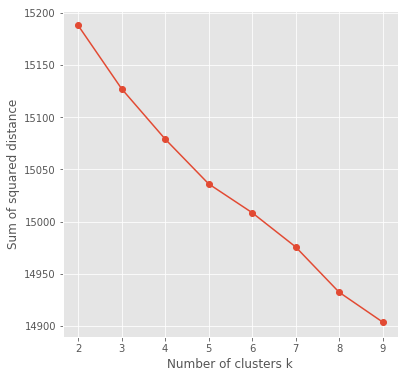

In [50]:
plt.figure(figsize=(6, 6))
plt.plot(k_list, sum_of_squared_distance, '-o')
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sum of squared distance')

3. Find best k using silhouse


In [51]:
k_list = []
k_silhouette = []
for k in range(3, 10):
    km = KMeans(n_clusters=k, max_iter=20)
    km.fit(abstract_train_transformed)
    labels = km.labels_
    k_list.append(k)
    k_silhouette.append(metrics.silhouette_score(abstract_train_transformed,
                               labels, metric='euclidean'))

Text(0, 0.5, 'Sum of squared distance')

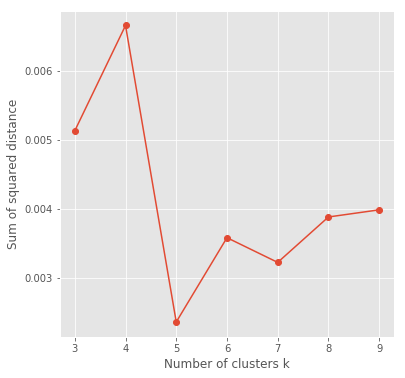

In [52]:
plt.figure(figsize=(6, 6))
plt.plot(k_list, k_silhouette, '-o')
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sum of squared distance')

4. Visualize k-means model with k = 4

In [53]:
k = 4
km = KMeans(n_clusters=k, max_iter=20)
km.fit(abstract_train_transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=20,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
labels = km.labels_
from sklearn import metrics
print(metrics.silhouette_score(abstract_train_transformed,
                               labels, metric='euclidean'))

0.002567927224489142


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=50)
X_abstract_transformed = tsne.fit_transform(abstract_train_transformed.toarray())

In [ ]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(labels)))
sns.scatterplot(X_abstract_transformed[:,0],
                X_abstract_transformed[:,1],
                hue=labels, legend='full', palette=palette)

In [ ]:
plt.figure(figsize = (10,10))
for i in range(k):
    plt.scatter(X_abstract_transformed[:,0][labels == i],
                X_abstract_transformed[:,1][labels  == i],
                label = str(i), alpha = 0.5)
plt.legend()